In [1]:
# unset PYTHONPATH first
from ko_text import *
from ko_crawler import *

import ast

In [2]:
nlp = NLP()

In [3]:
train_df = pd.read_csv('Data/morphs/train_morphs_final.csv', encoding = 'utf-8')
test_df = pd.read_csv('Data/morphs/test_morphs_final.csv', encoding = 'utf-8')

# 용량을 줄이기 위해 '단어 단어' 꼴로 묶어둔 token을 ['단어', '단어'] 꼴로 풀기
train_df['Token'] = [token.split() for token in train_df['Token']]
test_df['Token'] = [token.split() for token in test_df['Token']]

In [4]:
print(train_df.shape)

(82963, 3)


In [5]:
Counter(train_df['Section'])

Counter({'IT과학': 9836,
         '경제': 8050,
         '국제': 9677,
         '기업': 9604,
         '문화': 9313,
         '부동산': 9714,
         '사회': 9325,
         '정치': 8875,
         '증권': 8569})

# 가장 문제가 많은 기업, 증권 기사를 제거하면?

In [6]:
train_df = train_df[~train_df['Section'].isin(['증권','기업'])]
test_df = test_df[~test_df['Section'].isin(['증권','기업'])]

# 가장 문제가 많은 IT과학, 기업, 증권 기사를 제거하면?

In [6]:
train_df = train_df[~train_df['Section'].isin(['증권','기업','IT과학'])]
test_df = test_df[~test_df['Section'].isin(['증권','기업','IT과학'])]

In [7]:
Counter(train_df['Section'])

Counter({'경제': 8050,
         '국제': 9677,
         '문화': 9313,
         '부동산': 9714,
         '사회': 9325,
         '정치': 8875})

In [8]:
Counter(test_df['Section'])

Counter({'경제': 1873,
         '국제': 2422,
         '문화': 2310,
         '부동산': 2451,
         '사회': 2334,
         '정치': 2307})

<br>


# **Doc2Vec**

## **1. Doc2Vec 모델 불러오기**

In [9]:
# 가장 성능이 좋았던 모델들 호출
nlp.load_Doc2Vec_model('Doc2Vec_model/Doc2Vec_dm=True&cc=82963&vs=300&win=10&neg=5&min=10&sample=1e-05&epochs=10')

## **2. Doc2Vec으로 벡터 추정 분포 확인**

In [10]:
test_token_for_display, test_tag_for_display = nlp.extract_a_equally_splited_batch(test_df['Token'], test_df['Section'], 300)

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## tsne

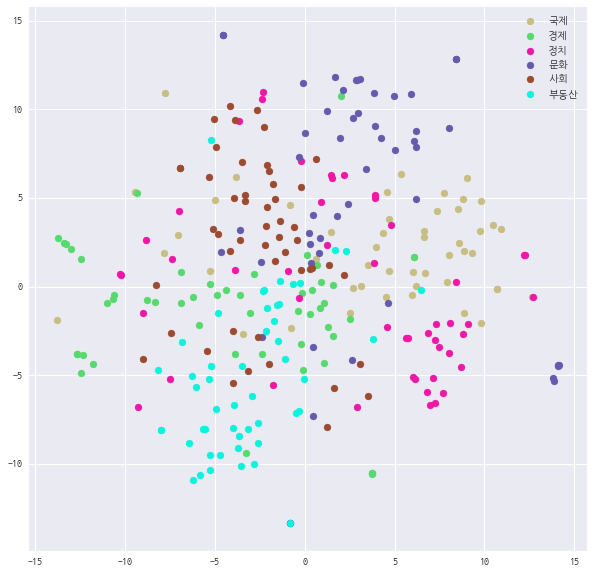

In [30]:
X =nlp.infer_vectors_with_Doc2Vec(test_token_for_display)

tsne= TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
scatter_df = pd.DataFrame(X_tsne,
                          index = test_tag_for_display,
                          columns = ['x','y'])

plt.figure(figsize = (10, 10))

for section in set(test_df['Section']):
    temp_df = scatter_df[scatter_df.index == section]
    plt.scatter(temp_df['x'].values, temp_df['y'].values, label = section, c = np.random.rand(3,))

plt.legend(loc = 'best')
plt.savefig('추정된 벡터 분포 t-sne ver')

## **Doc2Vec train** 

In [7]:
'''nlp.train_Doc2Vec_model(train_df['Token'],
                        train_df['Section'],
                        n_epochs = 10)'''

"nlp.train_Doc2Vec_model(train_df['Token'],\n                        train_df['Section'],\n                        n_epochs = 10)"

## **Doc2Vec 학습결과 확인**

#### **88000개 문서로 build하고 87000개 문서로 train**

In [13]:
nlp.Doc2Vec_model.most_similar('인공')

[('지능', 0.9414902925491333),
 ('빅데이터', 0.7357947826385498),
 ('음성인식', 0.7320722341537476),
 ('사물인터넷', 0.7252418994903564),
 ('접목', 0.6725608110427856),
 ('러닝', 0.6664267182350159),
 ('머신', 0.6464930772781372),
 ('기계학습', 0.64275062084198),
 ('로봇', 0.6422725915908813),
 ('자연어', 0.6374872326850891)]

# <br>


<br>


## **Data setting**

In [14]:
##################################
# 한 label마다 학습할 단어의 수
train_size_for_each_label = 8000
test_size_for_each_label = 1000
###################################


# 분류기의 성능을 테스트하기 위해 선정된 section list
testing_section_ls = np.unique(train_df['Section'])
#testing_section_ls = ['사회','IT과학']

# 전체를 모두 학습하면 시간이 오래걸림.
# 분류기별 성능 비교를 위해, 부분만 학습하기 위한 전처리 작업
train_df2 = train_df[train_df['Section'].isin(testing_section_ls)]
train_df2.index = np.arange(0,len(train_df2))

test_df2 = test_df[test_df['Section'].isin(testing_section_ls)]
test_df2.index = np.arange(0,len(test_df2))

n_class = len(test_df2['Section'].unique())


# Doc2Vec으로 vector를 추정하기 위한 split 과정
train_batch_size = n_class * train_size_for_each_label
test_batch_size = n_class * test_size_for_each_label

X_train, y_train = nlp.extract_a_equally_splited_batch(train_df2['Token'], train_df2['Section'], train_batch_size)
X_test, y_test =  nlp.extract_a_equally_splited_batch(test_df2['Token'],test_df2['Section'], test_batch_size)

#print(1)

X_train = nlp.infer_vectors_with_Doc2Vec(X_train)
y_train = y_train

X_test = nlp.infer_vectors_with_Doc2Vec(X_test)
y_test = y_test

from collections import Counter
Counter(y_train)

Counter({'경제': 8000,
         '국제': 8000,
         '문화': 8000,
         '부동산': 8000,
         '사회': 8000,
         '정치': 8000})

In [15]:
Counter(y_test)

Counter({'경제': 1000,
         '국제': 1000,
         '문화': 1000,
         '부동산': 1000,
         '사회': 1000,
         '정치': 1000})

<br>


In [16]:
from sklearn.metrics import confusion_matrix

# **Logistic Regression**

In [17]:
clf = LogisticRegression(solver = 'newton-cg',
                         multi_class = 'multinomial')


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.8035


# 테스트

In [13]:
k = 1400

' '.join(test_df['Token'].iloc[k])

'해외 바이어 인산인해 상위 수출 품목 일반 기계 정밀 기계 섬유 직물 지난해 대기업 반도체 수출 호조 영향 으로 중소기업 수출 비중 만에 감소 세로 돌아선 으로 나타났다 통계청 관세청 발표 기업 특성 무역 통계 중소기업 수출입 현황 보면 지난해 중소기업 수출 달러 보다 증가 했다 이는 같은 기간 전체 기업 수출 증가 크게 미치지 하는 수준 이다 수출 증가 속도 더딘 전체 수출 에서 중소기업 차지 하는 비중 기록 보다 포인트 하락 했다 중소기업 수출 비중 대비 포인트 상승 했다가 만에 하락 세로 반전 했다 관세청 관계자 대기업 반도체 전체 수출 증가 주도하면서 상대 으로 중소기업 수출 비중 줄어든 으로 보인다라고 했다 중소기업 수출 산업 별로 보면 제조업 보다 서비스업 증가 했다 재화 성질 별로 자본 원자재 각각 증가 했다 소비재 늘었다 수출 품목 에서는 일반 기계 비중 가장 많았고 정밀 기계 섬유 직물 이었다 지역별 로는 동남아 수출 비중 가장 컸고 중국 미국 이었다 대비 증가 동남아 가장 높았다 지난해 중소기업 수입 보다 증가 달러였다 전체 수입 에서 차지 하는 비중 보다 포인트 하락 했다'

In [14]:
clf.predict(nlp.infer_vectors_with_Doc2Vec([test_df['Token'].iloc[k]]))

array(['경제'], dtype='<U4')

# 분류 결과

In [18]:
result_df = pd.DataFrame(confusion_matrix(y_test, y_pred) ,
                         index = sorted(train_df['Section'].unique()),
                         columns = sorted(train_df['Section'].unique()))

result_df

,경제,국제,문화,부동산,사회,정치
경제,778,66,17,45,55,39
국제,79,806,28,7,33,47
문화,11,21,840,13,84,31
부동산,46,5,16,866,52,15
사회,62,25,47,48,764,54
정치,53,54,23,7,96,767


### 경제,기업 기사를 제일 못맞춘다. 정확도가 50%수준..

### 문화 기사와 부동산, 증권 기사는 잘 맞춘다. 

### **증권 기사를 잘 맞추는 이유는 대부분 기사를 증권 기사라고 분류하기 때문**

## 너무 많은 수의 기사를 [증권,사회] 기사라고 분류한다.

In [19]:
result_df.sum(axis = 0)

경제     1029
국제      977
문화      971
부동산     986
사회     1084
정치      953
dtype: int64

<br> 


# 왜 그럴까?

# 각 카테고리 별, 토큰 길이의 평균은?

In [20]:
train_df.groupby('Section')['Num of Tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
Section,,,,,,,,
경제,8050.0,215.267702,144.405833,51.0,114.0,174.0,279.0,2129.0
국제,9677.0,244.187765,131.619560,51.0,154.0,219.0,300.0,1342.0
문화,9313.0,248.453452,258.583833,51.0,112.0,176.0,314.0,4327.0
부동산,9714.0,224.478691,136.277920,51.0,130.0,188.0,277.0,1302.0
사회,9325.0,187.522681,121.342611,51.0,107.0,156.0,232.0,2020.0
정치,8875.0,240.445746,147.590659,51.0,134.0,203.0,313.0,1776.0


# 길이가 짧은 기사들은 하나로 몰아서 분류해버리는 경향이 있다


In [21]:
from collections import OrderedDict

section_ls = train_df['Section'].unique()

store_dict = OrderedDict(\
                         {'Token의 수 n개 이상' : [],
                          'Token의 수 n개 이하' : []})

for section in section_ls:
    store_dict[section] = []


## token의 수 50이상 100 이하

### 길이가 짧으면 증권, 사회 기사는 매우 잘 분류하지만, 정치, IT과학, 국제 기사는 잘 분류하지 못한다.

In [22]:
lower_limit = 50
upper_limit = 100

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


경제 카테고리의 분류 정확도는 88.00% 
사회 카테고리의 분류 정확도는 80.00% 
국제 카테고리의 분류 정확도는 65.00% 
부동산 카테고리의 분류 정확도는 85.00% 
정치 카테고리의 분류 정확도는 72.00% 
문화 카테고리의 분류 정확도는 87.00% 


## token의 수 100개 이상, 300개 이하

### 길이가 길어지면 경제, 사회 기사의 정확도는 떨어지지만, 반대로 부동산, 정치, IT과학 기사의 정확도가 급상승...

In [23]:
lower_limit = 100
upper_limit = 300

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


경제 카테고리의 분류 정확도는 71.00% 
사회 카테고리의 분류 정확도는 74.00% 
국제 카테고리의 분류 정확도는 83.00% 
부동산 카테고리의 분류 정확도는 85.00% 
정치 카테고리의 분류 정확도는 68.00% 
문화 카테고리의 분류 정확도는 86.00% 


## token의 수 300개 이상, 500 이하

In [24]:
lower_limit = 300
upper_limit = 500

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


경제 카테고리의 분류 정확도는 74.00% 
사회 카테고리의 분류 정확도는 76.00% 
국제 카테고리의 분류 정확도는 82.00% 
부동산 카테고리의 분류 정확도는 92.00% 
정치 카테고리의 분류 정확도는 69.00% 
문화 카테고리의 분류 정확도는 88.00% 


## token의 수 500개 초과

In [25]:
lower_limit = 500
upper_limit = 10000

temp_df = test_df[test_df['Num of Tokens'] > lower_limit]
temp_df = test_df[test_df['Num of Tokens'] < upper_limit]

store_dict['Token의 수 n개 이상'].append(lower_limit)
store_dict['Token의 수 n개 이하'].append(upper_limit)

for section in section_ls:
    temp_section_df = temp_df[temp_df['Section'] == section]

    temp_token_ls = temp_section_df['Token'].tolist()[:100] #100개만
    temp_tag_ls = temp_section_df['Section'].tolist()[:100]

    temp_pred = clf.predict(nlp.infer_vectors_with_Doc2Vec(temp_token_ls))
    
    store_dict[section].append('%s %s'%(round(accuracy_score(temp_tag_ls, temp_pred) * 100, 2), '%'))
    print('%s 카테고리의 분류 정확도는 %.2f%% '%(section, accuracy_score(temp_tag_ls, temp_pred) * 100))


경제 카테고리의 분류 정확도는 75.00% 
사회 카테고리의 분류 정확도는 74.00% 
국제 카테고리의 분류 정확도는 79.00% 
부동산 카테고리의 분류 정확도는 89.00% 
정치 카테고리의 분류 정확도는 69.00% 
문화 카테고리의 분류 정확도는 84.00% 


In [26]:
pd.DataFrame(store_dict)

,Token의 수 n개 이상,Token의 수 n개 이하,경제,사회,국제,부동산,정치,문화
0,50,100,88.0 %,80.0 %,65.0 %,85.0 %,72.0 %,87.0 %
1,100,300,71.0 %,74.0 %,83.0 %,85.0 %,68.0 %,86.0 %
2,300,500,74.0 %,76.0 %,82.0 %,92.0 %,69.0 %,88.0 %
3,500,10000,75.0 %,74.0 %,79.0 %,89.0 %,69.0 %,84.0 %


# **Decision Tree**

Decision Tree 모델은 feature들이 각각 의미있는 변수들이면서, 독립적으로 사용될 수 있을 때 유용한 방법이다.


각 변수별로 적절한 기준선을 찾아 공간을 나누기 때문.

따라서 Doc2Vec과 같이 좌표평면상에서 벡터의 위치가 아무런 의미가 없는 경우, 학습 효과가 현저하게 떨어진다.

In [149]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [150]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.84


<br>



# **RandomForestClassifier**

In [151]:
from sklearn.ensemble import RandomForestClassifier

In [152]:
clf = RandomForestClassifier(n_estimators=100,  n_jobs = -1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
    
print('Accuracy : ', accuracy_score(y_pred, y_test))

Accuracy :  0.91


<br>



# **Neural Net**

In [153]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

## **Data Preprocessing**

In [154]:
X_train_nn = np.array(X_train).astype('float32')
y_train_nn = pd.get_dummies(y_train).values.astype('float32')


X_test_nn = np.array(X_test).astype('float32')
y_test_nn = pd.get_dummies(y_test).values.astype('float32')

In [155]:
print(X_train_nn.shape, y_train_nn.shape, X_test_nn.shape, y_test_nn.shape)

(19876, 100) (19876, 2) (200, 100) (200, 2)


## **Build Layers**

In [162]:
# reset graphs
tf.reset_default_graph() 

# mini-batches
batch_size = X_train_nn.shape[0] // 5
dataset = tf.data.Dataset.from_tensor_slices((X_train_nn, y_train_nn))
dataset = dataset.batch(batch_size)

# building placeholder
X = tf.placeholder(tf.float32, shape = [None, nlp.Doc2Vec_model.vector_size])
Y = tf.placeholder(tf.float32, shape = [None, n_class])
keep_prob = tf.placeholder(tf.float32)

# building layers
n_neuron = 100

W1 = tf.get_variable('W1', shape = ([nlp.Doc2Vec_model.vector_size, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable('W2', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable('W3', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable('W4', shape = ([n_neuron, n_neuron]), initializer = tf.contrib.layers.xavier_initializer())
W5 = tf.get_variable('W5', shape = ([n_neuron, n_class]), initializer = tf.contrib.layers.xavier_initializer())

b1 = tf.Variable(tf.random_normal([n_neuron]))
b2 = tf.Variable(tf.random_normal([n_neuron]))
b3 = tf.Variable(tf.random_normal([n_neuron]))
b4 = tf.Variable(tf.random_normal([n_neuron]))
b5 = tf.Variable(tf.random_normal([n_class]))

L1 = tf.nn.relu(tf.matmul(X,W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob = keep_prob)

L2 = tf.nn.relu(tf.matmul(L1,W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob = keep_prob)

L3 = tf.nn.relu(tf.matmul(L2,W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob = keep_prob)

L4 = tf.nn.relu(tf.matmul(L3,W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob = keep_prob)

logit = tf.matmul(L4,W5) + b5
hypothesis = tf.nn.softmax(tf.matmul(L4,W5) + b5)


# cost : cross - entropy cost 
lamb = 0.0001
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y)) + lamb * tf.reduce_sum(tf.square(W5))

# optimize
learning_rate = 0.0001
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# prediction
prediction = tf.argmax(hypothesis,1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1), prediction), dtype= tf.float32))



# restore results
train_cost_list = []
train_acc_list = []

test_cost_list = []
test_acc_list = []


# **Run**

### **mini-batch**

In [ ]:
# train_dict = {X: X_train, Y: y_train}
test_dict = {X: X_test_nn, Y: y_test_nn, keep_prob : 1}

training_epochs = 1500

iterator = dataset.make_initializable_iterator()
f, l = iterator.get_next()

# launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    
    for epoch in range(training_epochs):
        # iterator initialize
        sess.run(iterator.initializer)
        avg_cost = 0

        while True:
            # mini-batch
            try:
                batch_x,  batch_y = sess.run([f, l])
                feed_dict = {X : batch_x, Y: batch_y, keep_prob : 0.7}
                
                c, _ = sess.run([cost, train], feed_dict = feed_dict)
                avg_cost += c
            
            except tf.errors.OutOfRangeError:
                    break
        
        acc, _, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
        
        train_cost_list.append(avg_cost)
        test_cost_list.append(test_cost)
            
        if (epoch+1) % (100) == 0 :
            
            test_acc_list.append(acc)
            
            print('Epoch : %s'%(epoch+1), 'cost :',test_cost)
            print('Accuracy :', acc)
            
        
    
    acc, y_pred, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
    

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(train_cost_list, label = 'train_cost')
plt.plot(test_cost_list, label = 'test_cost')
plt.legend(loc = 'best')

### **full-batch**

In [ ]:
# train_dict = {X: X_train, Y: y_train}
test_dict = {X: X_test_nn, Y: y_test_nn, keep_prob : 1}

training_epochs = 1000

iterator = dataset.make_initializable_iterator()
f, l = iterator.get_next()

# launch graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    
    
    for epoch in range(training_epochs):
        # iterator initialize
        avg_cost = 0

        while True:
            # mini-batch
            try:
                feed_dict = {X : X_train_nn, Y: y_train_nn, keep_prob : 0.7}
                
                c, _ = sess.run([cost, train], feed_dict = feed_dict)
                avg_cost += c
            
            except tf.errors.OutOfRangeError:
                    break
        
        acc, y_pred, test_cost = sess.run([accuracy, prediction, cost], feed_dict = test_dict)
        
        train_cost_list.append(avg_cost)
        test_cost_list.append(test_cost)
            
        if (epoch+1) % (100) == 0 :
            
            test_acc_list.append(acc)
            
            print('Epoch : %s'%(epoch+1), 'cost :',test_cost)
            print('Accuracy :', acc)
        #print(sess.run(tf.confusion_matrix(labels = tf.reshape(Y, [-1]), predictions = tf.reshape(y_pred, [-1])), feed_dict = test_dict))


In [ ]:
plt.figure(figsize = (12,6))
plt.plot(train_cost_list, label = 'train_cost')
plt.plot(test_cost_list, label = 'test_cost')
plt.legend(loc = 'best')